In [1]:
!pip install camb
!pip install bayesflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.1/407.1 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [3]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import camb
from camb import model
import bayesflow as bf
from scipy.stats import truncnorm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

I0000 00:00:1752403416.911684      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
K_MIN, K_MAX, N_K = 1e-4, 1.0, 256
k_grid = np.logspace(np.log10(K_MIN), np.log10(K_MAX), N_K).astype(np.float32)

def simulate_pk(theta, z: float = 0.0, *, sigma_frac: float = 0.05, seed: int | None = None):
    """Generate power spectrum for one cosmology with numerical stability"""
    rng = np.random.default_rng(seed)

    # Ensure numerical stability
    h = theta['H0'] / 100.0
    ombh2 = 0.02237
    omch2 = max(theta['Omega_m'] * h**2 - ombh2, 1e-5)  # Prevent negative values

    # CAMB setup with error handling
    try:
        pars = camb.CAMBparams()
        pars.set_accuracy(AccuracyBoost=2, lSampleBoost=2)
        pars.set_cosmology(H0=theta['H0'], ombh2=ombh2, omch2=omch2,
                           mnu=0.06, tau=0.0543)
        pars.InitPower.set_params(As=2.1e-9, ns=theta['n_s'])
        pars.set_matter_power(redshifts=[z], kmax=K_MAX*1.2, k_per_logint=30)
        pars.NonLinear = model.NonLinear_both
        pars.Transfer.high_precision = True

        pk_res = camb.get_matter_power_interpolator(
            pars, zs=[z], kmax=K_MAX*1.2, nonlinear=True,
            hubble_units=False, k_hunit=True
        )
        pk_interp = pk_res[0] if isinstance(pk_res, tuple) else pk_res

        # Calculate power spectrum with NaN protection
        P_nl = pk_interp.P(z, k_grid)
        if np.any(np.isnan(P_nl)):
            raise RuntimeError("NaN values in power spectrum")

        # Multiplicative noise preserves positivity
        noise = 1 + rng.normal(0.0, sigma_frac, P_nl.shape)
        noisyP = P_nl * noise

        return {'k': k_grid, 'P': noisyP.astype(np.float32)}

    except Exception as e:
        print(f"Error in CAMB: {e}")
        # Return fallback data with correct shape
        return {'k': k_grid, 'P': np.ones_like(k_grid) * 1e-10}

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

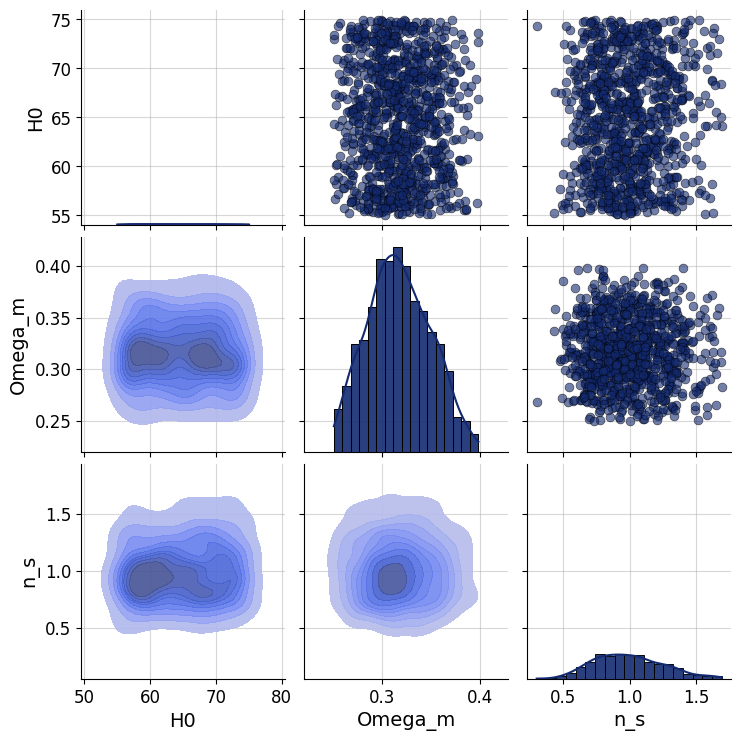

In [5]:
# ---- 2. BayesFlow simulator & wrappers -----------------------------

def prior():
    rng = np.random.default_rng()

    H0 = rng.uniform(55, 75)
    
    a_Om, b_Om = (0.25 - 0.315)/0.035, (0.40 - 0.315)/0.035
    Omega_m = truncnorm(a_Om, b_Om, loc=0.315, scale=0.035).rvs(random_state=rng)
    
    n_s = rng.gamma(shape=15, scale=1/15)
    while n_s < 0.3 or n_s > 1.7:
        n_s = rng.gamma(shape=15, scale=1/15)

    return dict(
        H0=np.float32(H0),
        Omega_m=np.float32(Omega_m),
        n_s=np.float32(n_s)
    )


def likelihood(H0, Omega_m, n_s, **kwargs):
    """Return a noisy matter power spectrum for the given cosmology."""
    theta = dict(H0=float(H0), Omega_m=float(Omega_m), n_s=float(n_s))
    return simulate_pk(theta)

# BayesFlow will chain the two callables automatically
simulator = bf.make_simulator([prior, likelihood])


#-------------------- Plot for debugging purposes -----------------------------
prior_samples = simulator.simulators[0].sample(1000)
grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["H0", "Omega_m", "n_s"]
)

In [6]:
# def augment_batch(batch, σ_x=0.02, σ_y=0.05, σ_m=0.01, σ_shift=0.1):
#     """Applies realistic augmentations for cosmological power spectra"""
#     batch = batch.copy()
#     rng = np.random.default_rng()
    
#     # Additive parameter noise (log space)
#     if 'x' in batch and np.issubdtype(batch['x'].dtype, np.floating):
#         batch['x'] += rng.normal(0, σ_x, batch['x'].shape)
    
#     # Summary variable augmentations
#     if 'y' in batch and np.issubdtype(batch['y'].dtype, np.floating):
#         # 1. Additive measurement noise
#         batch['y'] += rng.normal(0, σ_y, batch['y'].shape)
        
#         # 2. Systematic calibration error (global scale factor)
#         calibration_shift = 1 + rng.normal(0, σ_m, (batch['y'].shape[0], 1, 1))
#         batch['y'] *= calibration_shift
        
#         # 3. Vertical shift (simulates normalization uncertainty)
#         vertical_shift = rng.normal(0, σ_shift, (batch['y'].shape[0], 1, 1))
#         batch['y'] += vertical_shift
        
#     return batch

In [7]:
# ----- Adapter, networks, approximator (unchanged) ------------------------ 
adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("P", "summary_variables")
    .log(["inference_variables", "summary_variables"], p1=True)
    .expand_dims("summary_variables", axis=-1)
)
       

# -------- Print the adapter structure for debugging purposes --------
print(adapter)
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-5)

summary_net = bf.networks.TimeSeriesNetwork()

inference_net = bf.networks.CouplingFlow()
    
approximator = bf.approximators.ContinuousApproximator(
    adapter           = adapter,
    summary_network   = summary_net,
    inference_network = inference_net,
)
    
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    optimizer=optimizer, 
    inference_network=inference_net,
    summary_network=summary_net,
    approximator=approximator,
    metrics=["loss"],
    standardise=None
)

Adapter([0: ConvertDType -> 1: Concatenate(['H0', 'Omega_m', 'n_s'] -> 'inference_variables') -> 2: Rename('P' -> 'summary_variables') -> 3: Log -> 4: ExpandDims])
(2, 256, 1)
(2, 3)


In [8]:
# training_data = workflow.simulate(6000,num_workers=os.cpu_count()) # type: ignore
# validation_data = workflow.simulate(1200,num_workers=os.cpu_count()) # type: ignore

# np.savez_compressed("train.npz", **training_data)
# np.savez_compressed("val.npz", **validation_data)

# load the data
training_data = dict(np.load("/kaggle/input/wider-samples/train_wider_10000.npz"))
validation_data = dict(np.load("/kaggle/input/wider-samples/val.npz_wider_2000.npz"))

In [9]:
history = workflow.fit_offline(
    data=training_data,
    epochs=150,
    batch_size=256,
    validation_data=validation_data,
    callbacks=[
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,          # Reduce LR by half
            patience=6,          # Wait 6 epochs with no improvement
            min_lr=1e-6,         # Minimum LR
            verbose=1,
        )
    ]
)

I0000 00:00:1752403434.157444      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - loss: 3.6250 - val_loss: 2.5097 - learning_rate: 5.0000e-04
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 2.1571 - val_loss: 1.3174 - learning_rate: 5.0000e-04
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 1.5424 - val_loss: 1.1357 - learning_rate: 5.0000e-04
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 1.1850 - val_loss: 0.5536 - learning_rate: 5.0000e-04
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2783 - val_loss: -0.6303 - learning_rate: 5.0000e-04
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: -0.0468 - val_loss: -0.6225 - learning_rate: 5.0000e-04
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: -0.3634 - val_loss: -0.9034 - learning_rate: 5.0000e-04
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.8040 - val_loss: 1.5227 - learning_rate: 5.0000e-04
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.6224 - val_loss: -0

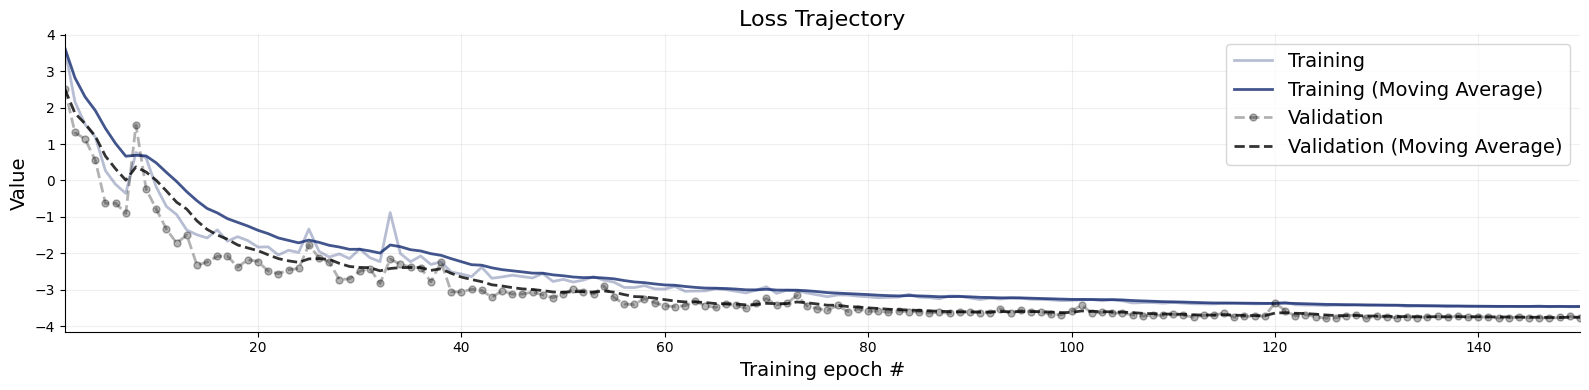

In [10]:
f = bf.diagnostics.plots.loss(history)

In [11]:
# test_sims = workflow.simulate(200,num_workers=os.cpu_count())
test_sims=dict(np.load("/kaggle/input/wider-samples/test.npz"))
# np.savez_compressed("test.npz", **test_sims)

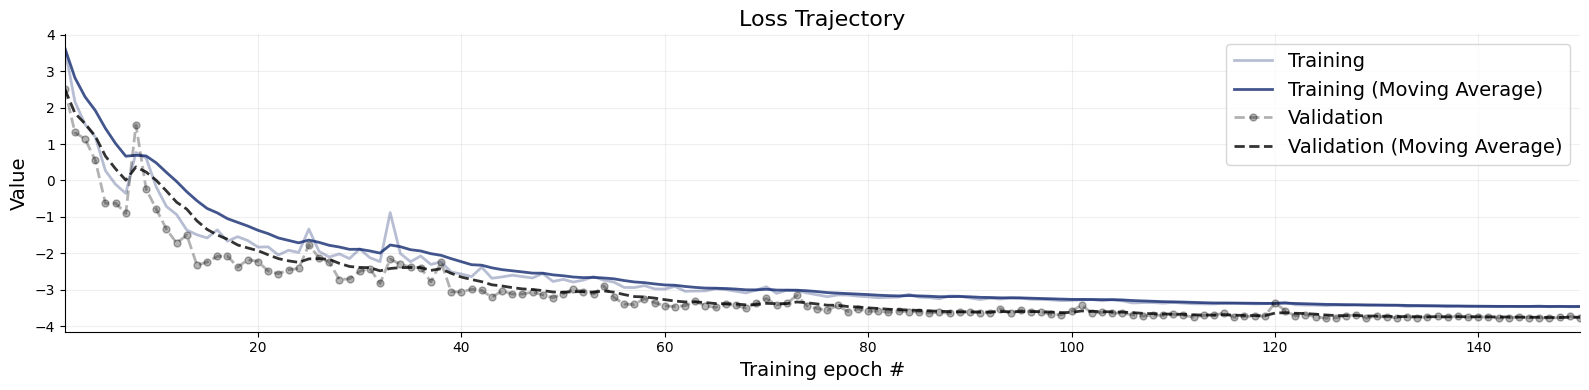

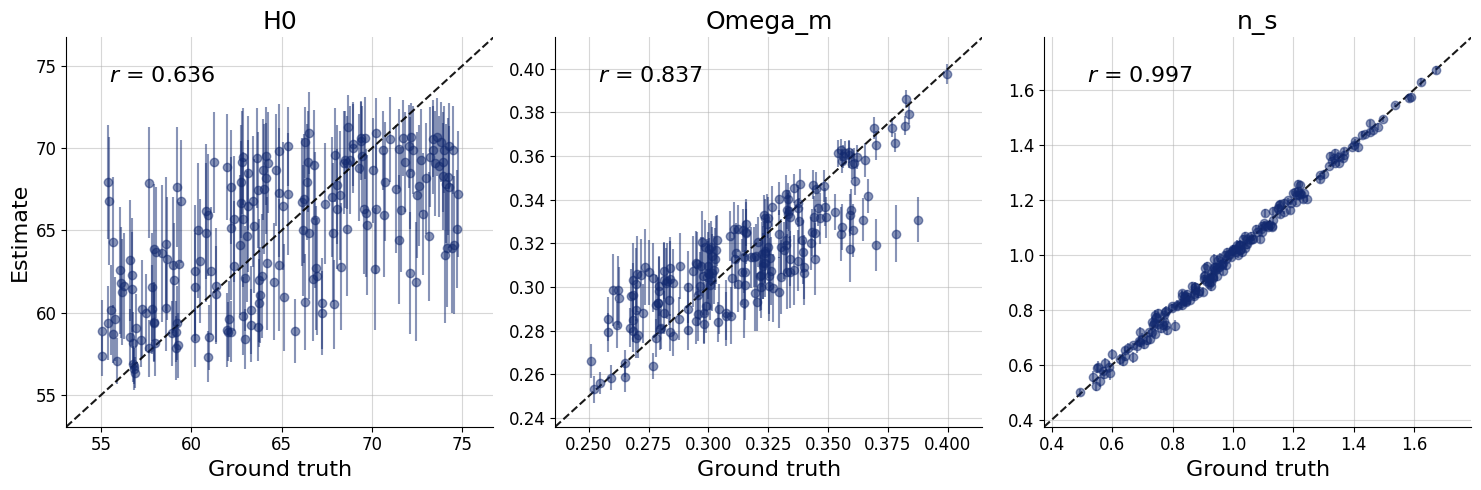

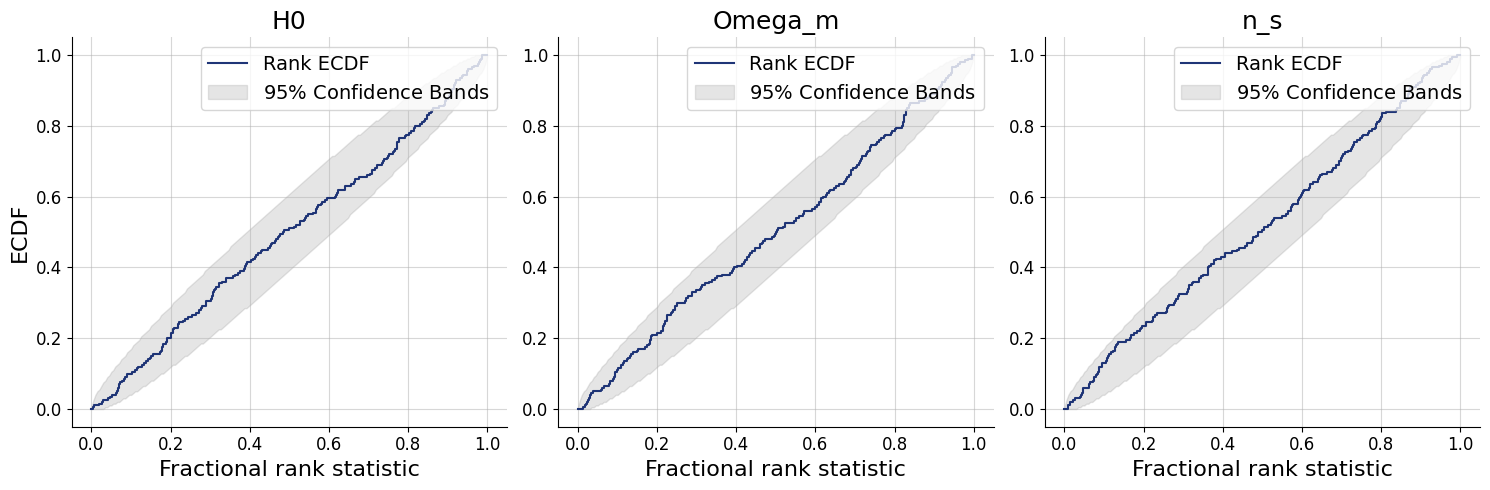

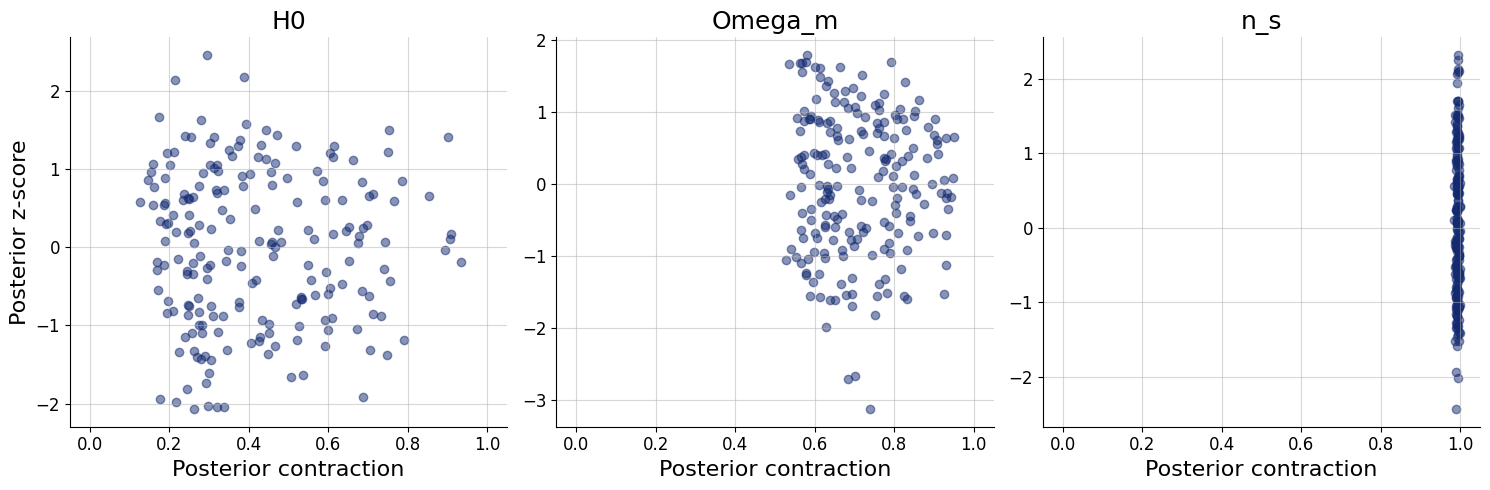

In [12]:
diagnostics=workflow.plot_default_diagnostics(test_data=test_sims)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

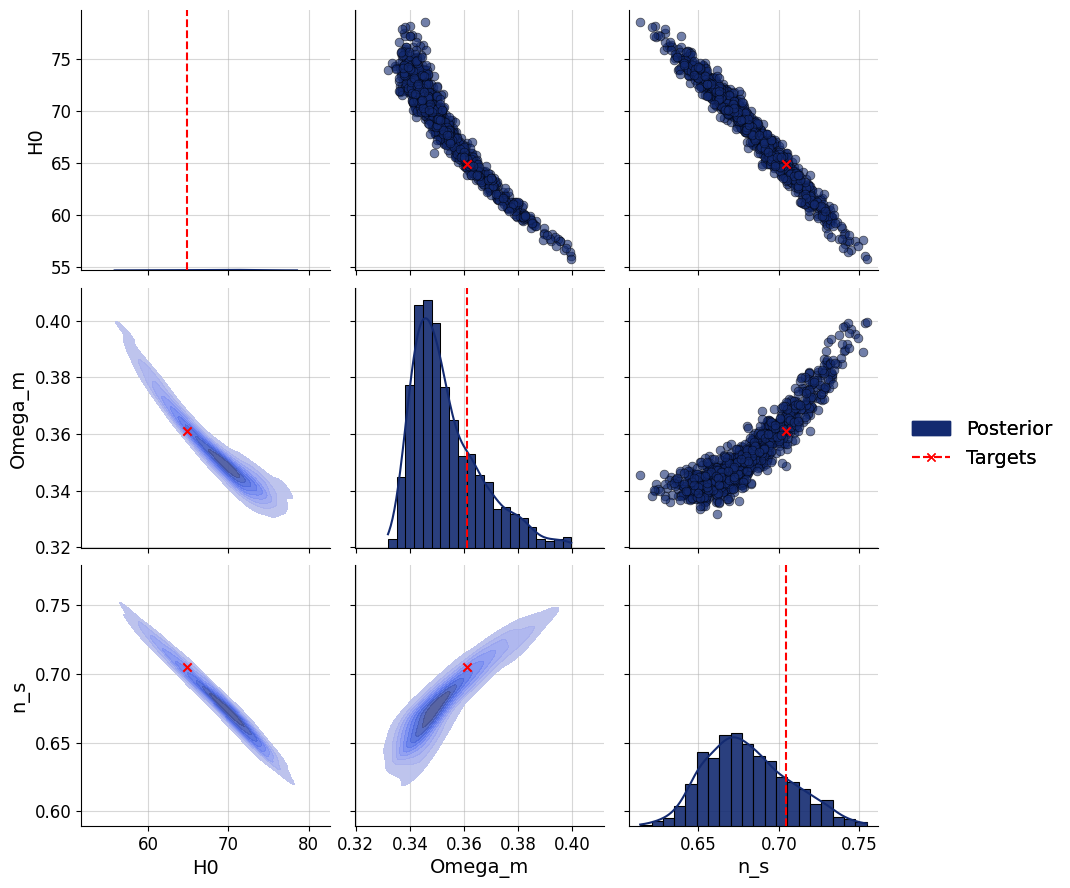

In [13]:
num_samples=1000
post_draws = workflow.sample(conditions=test_sims, num_samples=num_samples)
par_names = ["H0", "Omega_m", "n_s"]
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=test_sims,
    dataset_id=0,
    variable_names=par_names,
)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


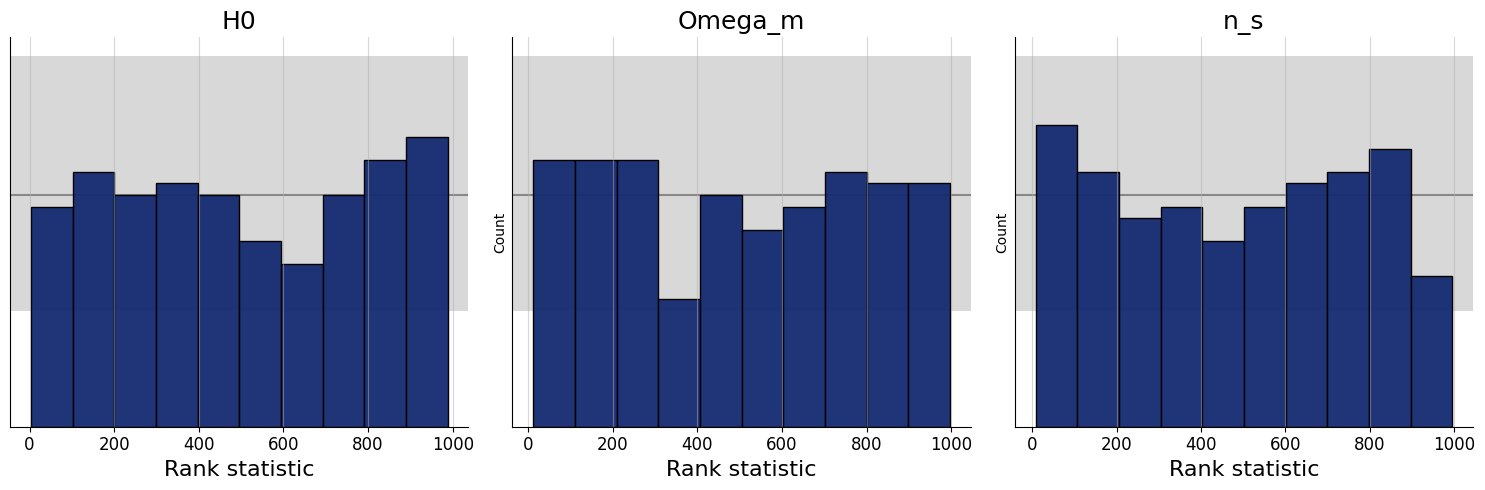

In [14]:
f = bf.diagnostics.plots.calibration_histogram(
    estimates= post_draws,
    targets=test_sims,
    variable_names=par_names
)

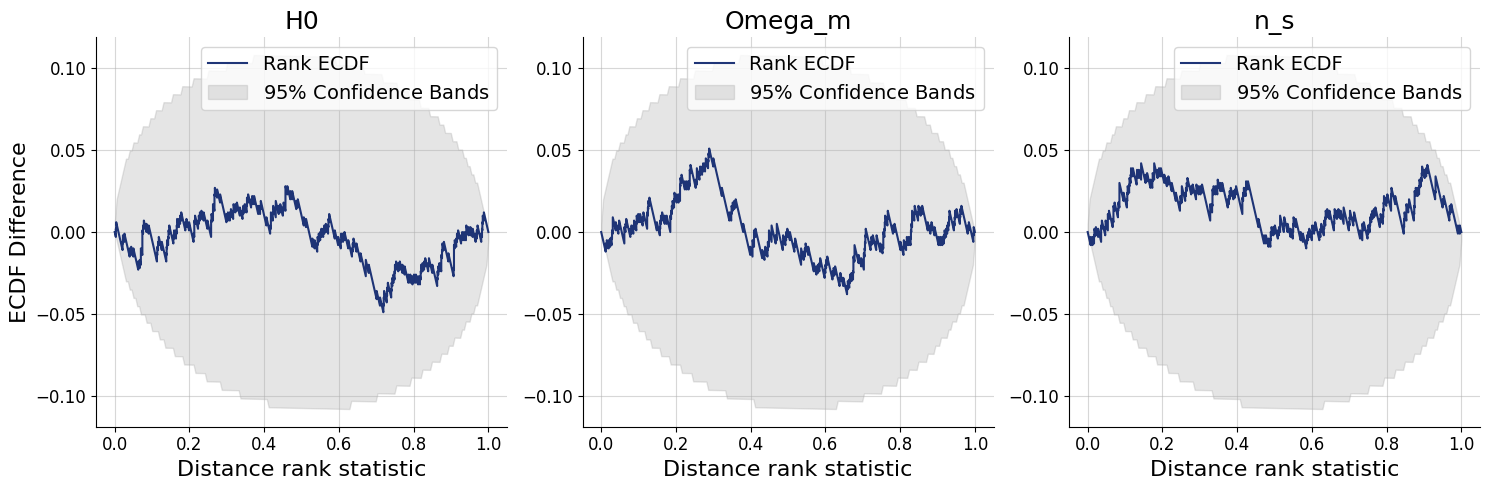

In [15]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=test_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

In [16]:
metrics = workflow.compute_default_diagnostics(test_data=test_sims)
metrics

,H0,Omega_m,n_s
NRMSE,0.319227,0.168706,0.024498
Posterior Contraction,0.368715,0.694909,0.992950
Calibration Error,0.018816,0.018289,0.016184


In [39]:
theta_true = dict(H0=68.0, Omega_m=0.32, n_s=0.965)
obs_pk = simulate_pk(theta_true)["P"].astype("float32")   # shape (N_k,)

conds = {"summary_variables": obs_pk[None, :, None]}      # (1, N_k, 1)

posterior = workflow.sample(
    conditions   = conds,
    num_samples  = num_samples,   # how many θ you want           # internal vectorisation, tweak if RAM-bound
)

df_samples = workflow.samples_to_data_frame(posterior)
print(df_samples.head(5))


          H0   Omega_m       n_s
0  72.263298  0.309440  0.943233
1  69.031105  0.319702  0.957566
2  59.380692  0.358529  1.002664
3  73.062813  0.305392  0.941554
4  68.365654  0.319202  0.960697
